# Similarity-based Learning - *k*-Nearest-Neighbor

In [ ]:
%reload_ext autoreload
%autoreload 2

In [7]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sn # For data sets

# Create a K-Nearest Neighbors Algorithm from Scratch in Python

- https://towardsdatascience.com/create-your-own-k-nearest-neighbors-algorithm-in-python-eb7093fc6339
- https://github.com/turnerluke/ML-algos/blob/main/knn/knn.py


Define functions and a Python class for the ML model

In [80]:
def most_common(lst):
    return max(set(lst), key=lst.count)


def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))


class KNeighborsClassifier():
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])

        return list(map(most_common, neighbors))

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy

## Example with IRIS data set

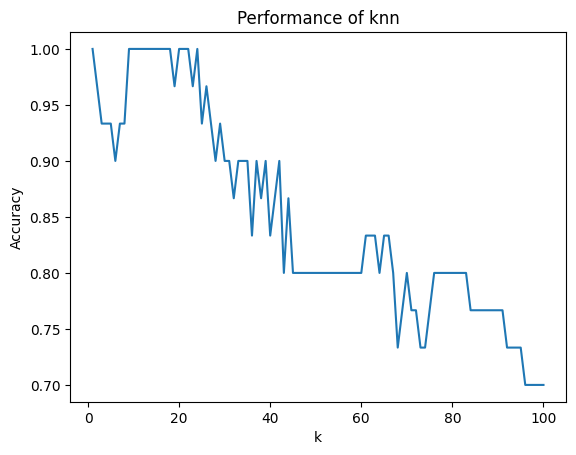

In [81]:
# Unpack the iris dataset, from UCI Machine Learning Repository
iris = datasets.load_iris()
X = iris['data']
y = iris['target']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocess data
ss = StandardScaler().fit(X_train)
X_train, X_test = ss.transform(X_train), ss.transform(X_test)

# Test knn model across varying ks
accuracies = []
ks = range(1, 101)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(X_train, y_train)
    accuracy = knn.evaluate(X_test, y_test)
    accuracies.append(accuracy)

# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

## Penguins

In [6]:
penguins = sn.load_dataset('penguins')
print(penguins.shape)

(344, 7)


In [15]:
penguins.groupby(['species', 'island', 'sex'])['body_mass_g'] \
    .count() \
    .reset_index() \
    .rename({'body_mass_g': 'N'}, axis=1)

,species,island,sex,N
0,Adelie,Biscoe,Female,22
1,Adelie,Biscoe,Male,22
2,Adelie,Dream,Female,27
3,Adelie,Dream,Male,28
4,Adelie,Torgersen,Female,24
5,Adelie,Torgersen,Male,23
6,Chinstrap,Dream,Female,34
7,Chinstrap,Dream,Male,34
8,Gentoo,Biscoe,Female,58
9,Gentoo,Biscoe,Male,61


# Text embedding - Vector Database

In [16]:
! ls /data/IFI8410/sess01/sentiment_labelled_sentences/*labelled.txt

/data/IFI8410/sess01/sentiment_labelled_sentences/amazon_cells_labelled.txt
/data/IFI8410/sess01/sentiment_labelled_sentences/imdb_labelled.txt
/data/IFI8410/sess01/sentiment_labelled_sentences/yelp_labelled.txt


In [20]:
reviews =  pd.read_csv('/data/IFI8410/sess01/sentiment_labelled_sentences/yelp_labelled.txt', delimiter='\t', header=None)
reviews.columns = ['text', 'sentiment']
print(f"Number of records: {reviews.shape[0]:1}")

Number of records: 1000


In [21]:
reviews.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## OpenAI
Using OpenAI API for Embedding

https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

In [22]:
! mkdir -p output

In [37]:
# Load your OpenAI API key from a secure location
API_KEY = open('/home/pmolnar/.secrets/openai_pmolnar_gsu_edu.apikey', 'r').read().strip()
os.environ['OPENAI_API_KEY'] = API_KEY

from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

# Do not execute accidentillay
if False and not os.path.isfile('output/embedded_reviews.csv'):
    reviews['ada_embedding'] = reviews.text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
    reviews.to_csv('output/embedded_reviews.csv', index=False)

In [31]:
reviews.head()

,text,sentiment,ada_embedding
0,Wow... Loved this place.,1,"[0.019262049347162247, -0.0041028293780982494,..."
1,Crust is not good.,0,"[-0.00298229418694973, 0.07532791048288345, -0..."
2,Not tasty and the texture was just nasty.,0,"[-0.02595783770084381, -0.025650784373283386, ..."
3,Stopped by during the late May bank holiday of...,1,"[-0.018199104815721512, 0.020299501717090607, ..."
4,The selection on the menu was great and so wer...,1,"[-0.024915141984820366, -0.04568932577967644, ..."


### Load embedded reviews

In [33]:
reviews2 = pd.read_csv('output/embedded_reviews.csv')
reviews2.dtypes

text             object
sentiment         int64
ada_embedding    object
dtype: object

In [36]:
reviews2['ada_embedding'] = reviews2.ada_embedding.apply(eval).apply(np.array)

## Faiss: A library for efficient similarity search

https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/

In [39]:
v = reviews2.iloc[0].ada_embedding
d = len(v)
print(f"Dimension: {d:,}")

Dimension: 1,536


In [40]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(d)   # build the index, d=size of vectors 

In [43]:
xb = np.stack(reviews2.ada_embedding, axis=0)
print(xb.shape)

(1000, 1536)


In [45]:
xb[:10, :5]

array([[ 0.01926205, -0.00410283, -0.04877627, -0.02298892, -0.02950114],
       [-0.00298229,  0.07532791, -0.00329729,  0.04522384,  0.008786  ],
       [-0.02595784, -0.02565078, -0.07444868, -0.01161489, -0.05682853],
       [-0.0181991 ,  0.0202995 , -0.04493026, -0.01291549, -0.01913841],
       [-0.02491514, -0.04568933, -0.01470155, -0.05348543,  0.03756935],
       [-0.01708727,  0.00289076, -0.09161158, -0.00512742,  0.00657823],
       [-0.03490983,  0.01276999, -0.1040806 ,  0.04228112,  0.04812106],
       [-0.00908457, -0.02693639, -0.06004231, -0.0040995 , -0.01300326],
       [-0.03598801, -0.03383813, -0.10865826, -0.02821711,  0.02165551],
       [ 0.01682344, -0.00691282, -0.07248396,  0.02368406, -0.02353491]])

In [46]:
# here we assume xb contains a n-by-d numpy matrix of type float32
index.add(xb)                  # add vectors to the index
print(f"Number of records: {index.ntotal:,}")

Number of records: 1,000


In [47]:
reviews2.iloc[17].text

'Waitress was a little slow in service.'

In [51]:
k = 4                          # we want 4 similar vectors

xq = np.stack([reviews2.iloc[17].ada_embedding])
D, I = index.search(xq, k)     # actual search
print(I)
print(D)


[[ 17 147 695 679]]
[[0.         0.45153064 0.6156649  0.6577745 ]]


In [55]:
for idx in I[0]:
    print(f"{reviews2.iloc[idx].text}")

Waitress was a little slow in service.
The service was a little slow , considering that were served by 3 people servers so the food was coming in a slow pace.
Went for lunch - service was slow.
Service was slow and not attentive.


### Ask questions

In [58]:
q_text = "How is the pizza?"
q_vec = get_embedding(q_text)

xq = np.stack([q_vec])
D, I = index.search(xq, k)     # actual search

for idx in I[0]:
    print(f"{reviews2.iloc[idx].text}")

This is some seriously good pizza and I'm an expert/connisseur on the topic.
The pizza selections are good.
I loved the grilled pizza, reminded me of legit Italian pizza.
Great Pizza and Salads!


### Sentiment Anlysis

In [82]:
input_text = "The steak was raw"
input_vec = get_embedding(input_text)

k = 5 
D, I = index.search(np.stack([input_vec]), k)     # actual search
matches = reviews2.iloc[I[0]][['text', 'sentiment']].copy()
matches['distance'] = D[0]
weights = 1.0/(1+D[0])
matches['weight'] = weights/weights.sum()
display(matches)
sentiment = np.sum(matches.sentiment * matches.weight)
print(f"Sentiment: {sentiment}")

,text,sentiment,distance,weight
684,Damn good steak.,1,0.817120,0.210975
449,My ribeye steak was cooked perfectly and had g...,1,0.923956,0.199259
118,Kind of hard to mess up a steak but they did.,0,0.932233,0.198406
701,I wasn't really impressed with Strip Steak.,0,0.944596,0.197144
688,The steak was amazing...rge fillet relleno was...,1,0.973919,0.194216


Sentiment: 0.6044497489929199


In [79]:
k = 5 

while True:
    print("\n\nEnter review: (Hit <Enter> to quit)")
    q_text = input()
    if len(q_text.strip()) == 0:
        break

    q_vec = get_embedding(q_text)
    D, I = index.search(np.stack([q_vec]), k)     # actual search
    
    matches = reviews2.iloc[I[0]][['text', 'sentiment']].copy()
    matches['distance'] = D[0]
    weights = 1.0/(1+D[0])
    matches['weight'] = weights/weights.sum()
    display(matches)
    
    sentiment = np.sum(matches.sentiment * matches.weight)
    print(f"Sentiment for: '{q_text:60}' is {sentiment:.1f}")



Enter review:


 the steak was raw and the potatoes were cold


,text,sentiment,distance,weight
7,The potatoes were like rubber and you could te...,0,0.947317,0.191136
954,"The fries were not hot, and neither was my bur...",0,0.973955,0.195033
987,"It lacked flavor, seemed undercooked, and dry.",0,1.013973,0.200789
612,The chicken I got was definitely reheated and ...,0,1.048057,0.205602
475,"Third, the cheese on my friend's burger was cold.",0,1.061219,0.207439


Sentiment for: 'the steak was raw and the potatoes were cold                ' is 0.0


Enter review:


 the steak was steaming hot and raw


,text,sentiment,distance,weight
684,Damn good steak.,1,0.847871,0.184574
449,My ribeye steak was cooked perfectly and had g...,1,0.936364,0.198635
477,The steaks are all well trimmed and also perfe...,1,0.946857,0.200260
118,Kind of hard to mess up a steak but they did.,0,0.994700,0.207557
688,The steak was amazing...rge fillet relleno was...,1,1.004128,0.208975


Sentiment for: 'the steak was steaming hot and raw                          ' is 0.8


Enter review:


# Reading
- Scikit-Learn Preprocessing https://scikit-learn.org/stable/modules/preprocessing.html 
- https://towardsdatascience.com/create-your-own-k-nearest-neighbors-algorithm-in-python-eb7093fc6339
- https://medium.com/gft-engineering/using-text-embeddings-and-approximate-nearest-neighbour-search-to-explore-shakespeares-plays-29e6bde05a16
- https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
- https://platform.openai.com/docs/guides/embeddings/use-cases
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Spending on OpenAI for this experiment
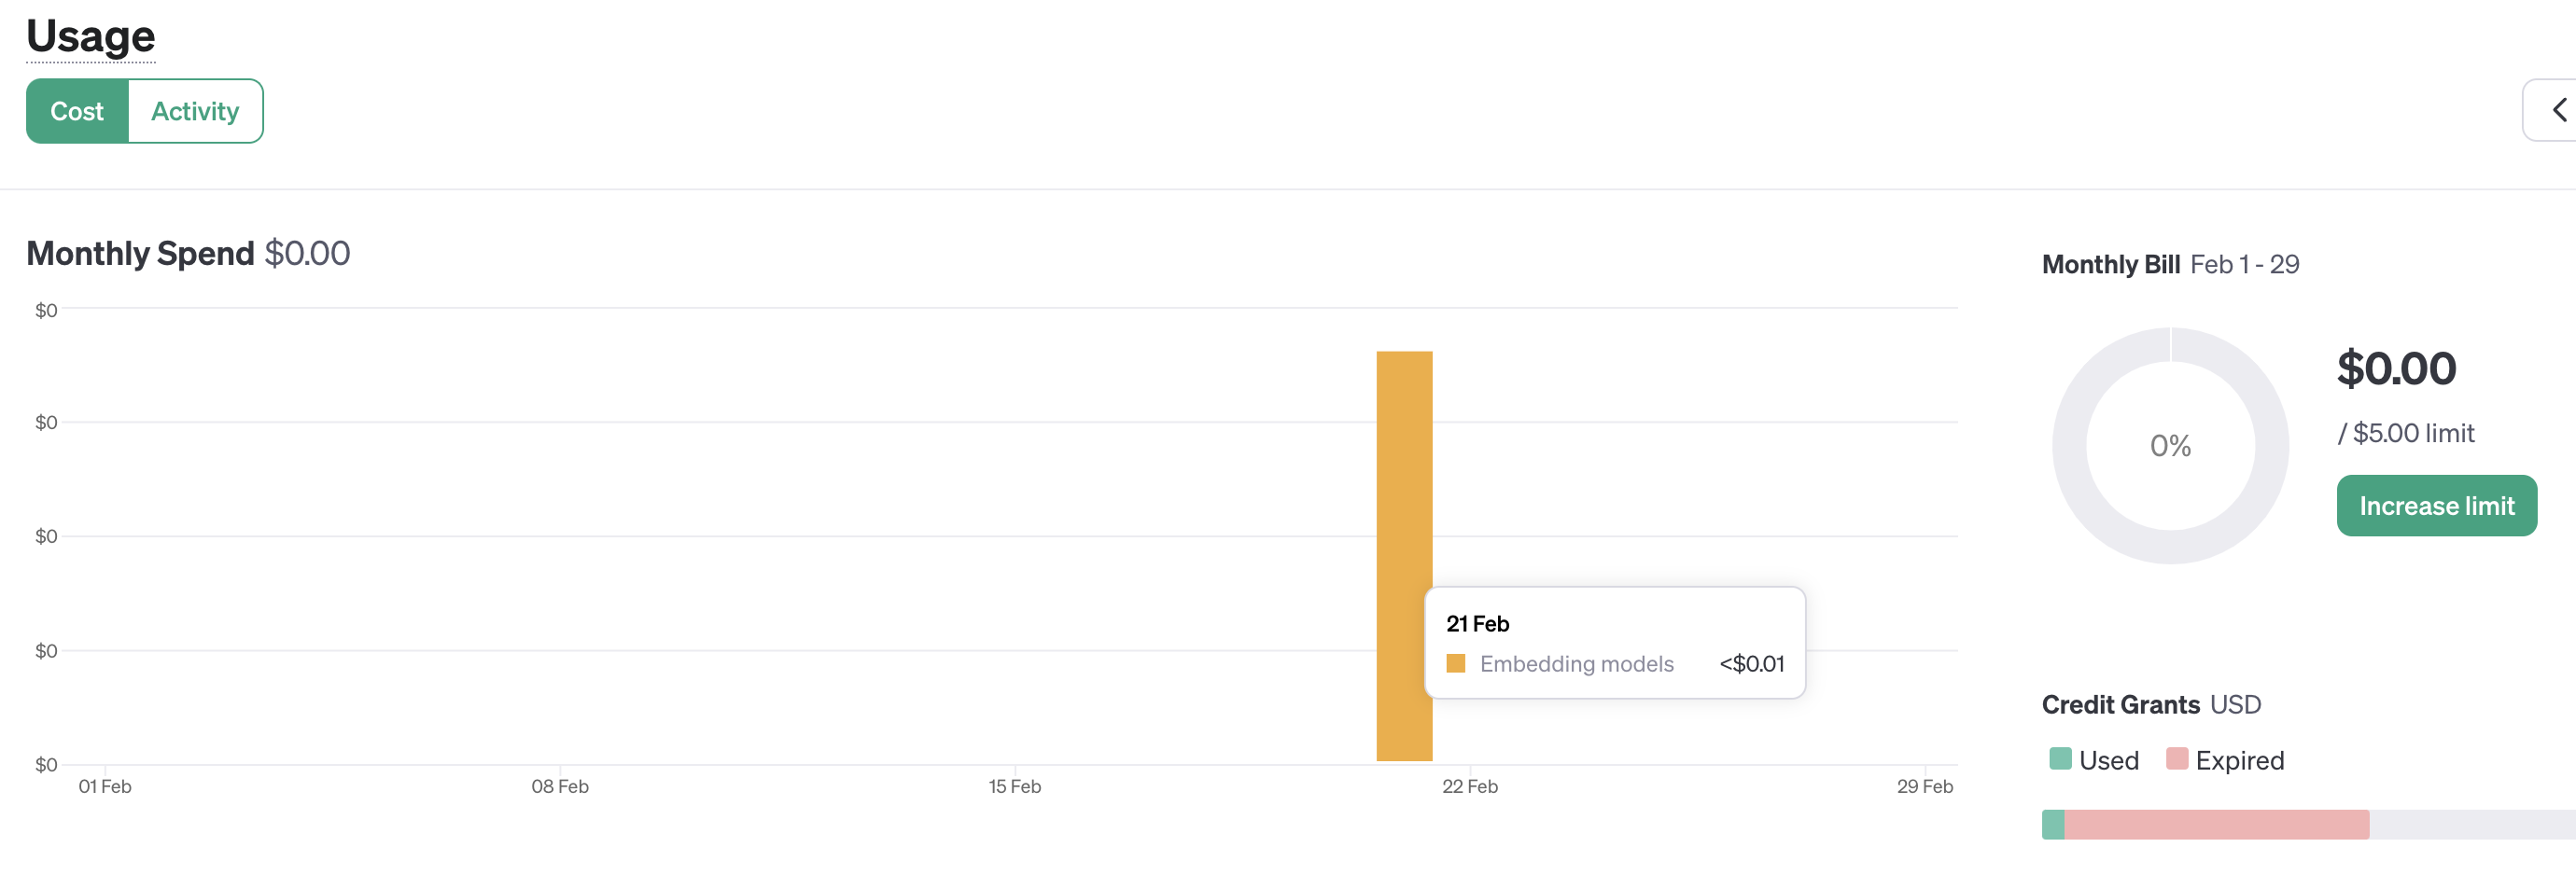